\# Student Performance Predictor of Yuluka

This notebook contains the code to implement a Neural Network (NN), using keras, to predict the performance of a student based on various factors.

---

## Table of Contents

1. [About Data](#about-data)
2. [Data Exploration](#data-exploration)
3. [Data Augmentation](#data-augmentation)
    - [Label Encoding](#label-encoding)
    - [Gaussian Noise](#gaussian-noise)
4. [Keras Model](#keras-model)
    - [Features Selection](#features-selection)
    - [Data Partitioning](#data-partitioning)
    - [Small Model](#small-model)
    - [Small Model Results](#small-model-results)
    - [Small Model with Regularization and Dropout](#small-model-with-regularization-and-dropout)
    - [Small Model with Regularization results](#small-model-with-regularization-results)
    - [Model with Raw Data](#model-with-raw-data)
    - [Model with Raw Data Results](#model-with-raw-data-results)
5. [Bayesian Optimization](#bayesian-optimization)
    - [Finding Best Hyperparameters](#finding-best-hyperparameters)
    - [Optimized Model](#optimized-model)
    - [Optimized Model results](#optimized-model-results)

---

## About Data

The dataset used in this notebook provides a comprehensive overview of various factors affecting student performance in exams. It includes information on study habits, attendance, parental involvement, and other aspects influencing academic success.

The features are:

- Hours_Studied
- Attendance
- Parental_Involvement
- Access_to_Resources
- Extracurricular_Activities
- Sleep_Hours
- Previous_Scores
- Motivation_Level
- Internet_Access
- Tutoring_Sessions
- Family_Income
- Teacher_Quality
- School_Type
- Peer_Influence
- Physical_Activity
- Learning_Disabilities
- Parental_Education_Level
- Distance_from_Home
- Gender

And the target is:

- Exam_Score

You can **_find the dataset_** [here](https://www.kaggle.com/datasets/lainguyn123/student-performance-factors/data).

---

## Data exploration

Let's load the dataset:

In [3]:
import pandas as pd

#mount drive
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = '/content/drive/MyDrive/ia2&pdg/data/StudentPerformanceFactors.csv'

df = pd.read_csv(DATA_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now, let's take an overview of the data:

In [4]:
df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [5]:
print(f'DF shape: {df.shape}')
print(f'Quantity of columns: {df.columns.size}')
print(f'Quantity of rows: {df.index.size}')

DF shape: (6607, 20)
Quantity of columns: 20
Quantity of rows: 6607


In [ ]:
df.dtypes

Hours_Studied                  int64
Attendance                     int64
Parental_Involvement          object
Access_to_Resources           object
Extracurricular_Activities    object
Sleep_Hours                    int64
Previous_Scores                int64
Motivation_Level              object
Internet_Access               object
Tutoring_Sessions              int64
Family_Income                 object
Teacher_Quality               object
School_Type                   object
Peer_Influence                object
Physical_Activity              int64
Learning_Disabilities         object
Parental_Education_Level      object
Distance_from_Home            object
Gender                        object
Exam_Score                     int64
dtype: object

In [6]:
df.notna().sum()

,0
Hours_Studied,6607
Attendance,6607
Parental_Involvement,6607
Access_to_Resources,6607
Extracurricular_Activities,6607
Sleep_Hours,6607
Previous_Scores,6607
Motivation_Level,6607
Internet_Access,6607
Tutoring_Sessions,6607


In [7]:
df.isna().sum()

,0
Hours_Studied,0
Attendance,0
Parental_Involvement,0
Access_to_Resources,0
Extracurricular_Activities,0
Sleep_Hours,0
Previous_Scores,0
Motivation_Level,0
Internet_Access,0
Tutoring_Sessions,0


There are some NaN values, but since they're not many and the data is enough, I'll drop them:

In [8]:
df.dropna(inplace=True)

Now, the data has no NaN values, so there won't be problems with that when training the model.

The new shape of the dataset is:

In [9]:
print(f'DF shape: {df.shape}')
print(f'Quantity of columns: {df.columns.size}')
print(f'Quantity of rows: {df.index.size}')

DF shape: (6378, 20)
Quantity of columns: 20
Quantity of rows: 6378


---

## Data Augmentation: Gaussian noise

To increase the data, let's use data augmentation.

To do that, I'll be introducing _Gaussian noise_ in my data.

This technique consists of adding a small amount of noise to the features to genreate more instances with some small differences with the original ones.

### Label Encoding

To be able to use Gaussian Noise, it is necessary to transform the categorical variables to continuous variables.

In [10]:
x_categorical = df.select_dtypes(include=['object'])
x_categorical.head()

,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Motivation_Level,Internet_Access,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender
0,Low,High,No,Low,Yes,Low,Medium,Public,Positive,No,High School,Near,Male
1,Low,Medium,No,Low,Yes,Medium,Medium,Public,Negative,No,College,Moderate,Female
2,Medium,Medium,Yes,Medium,Yes,Medium,Medium,Public,Neutral,No,Postgraduate,Near,Male
3,Low,Medium,Yes,Medium,Yes,Medium,Medium,Public,Negative,No,High School,Moderate,Male
4,Medium,Medium,Yes,Medium,Yes,Medium,High,Public,Neutral,No,College,Near,Female


In [11]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

df_encoded = df.copy()

label_encoders = {}

for column in x_categorical.columns:
    lbl_enc = LabelEncoder()
    df_encoded[column] = lbl_enc.fit_transform(df[column])
    label_encoders[column] = lbl_enc

In [12]:
df_encoded.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,1,0,0,7,73,1,1,0,1,2,1,2,3,0,1,2,1,67
1,19,64,1,2,0,8,59,1,1,2,2,2,1,0,4,0,0,1,0,61
2,24,98,2,2,1,7,91,2,1,2,2,2,1,1,4,0,2,2,1,74
3,29,89,1,2,1,8,98,2,1,1,2,2,1,0,4,0,1,1,1,71
4,19,92,2,2,1,6,65,2,1,3,2,0,1,1,4,0,0,2,0,70


In [13]:
for column in x_categorical.columns:
    print(f'{column}: {np.unique(df[column])}')
    print(f'{column}: {np.unique(df_encoded[column])}')

Parental_Involvement: ['High' 'Low' 'Medium']
Parental_Involvement: [0 1 2]
Access_to_Resources: ['High' 'Low' 'Medium']
Access_to_Resources: [0 1 2]
Extracurricular_Activities: ['No' 'Yes']
Extracurricular_Activities: [0 1]
Motivation_Level: ['High' 'Low' 'Medium']
Motivation_Level: [0 1 2]
Internet_Access: ['No' 'Yes']
Internet_Access: [0 1]
Family_Income: ['High' 'Low' 'Medium']
Family_Income: [0 1 2]
Teacher_Quality: ['High' 'Low' 'Medium']
Teacher_Quality: [0 1 2]
School_Type: ['Private' 'Public']
School_Type: [0 1]
Peer_Influence: ['Negative' 'Neutral' 'Positive']
Peer_Influence: [0 1 2]
Learning_Disabilities: ['No' 'Yes']
Learning_Disabilities: [0 1]
Parental_Education_Level: ['College' 'High School' 'Postgraduate']
Parental_Education_Level: [0 1 2]
Distance_from_Home: ['Far' 'Moderate' 'Near']
Distance_from_Home: [0 1 2]
Gender: ['Female' 'Male']
Gender: [0 1]


### Gaussian Noise

In [14]:
# Add noise to the categorical variables
noise = np.random.normal(0, 0.01, df_encoded[x_categorical.columns].shape)

df_noise = df_encoded.copy()

df_noise[x_categorical.columns] = df_noise[x_categorical.columns] + noise

# Round the values to the nearest integer
df_noise[x_categorical.columns] = np.round(df_noise[x_categorical.columns]).astype(int)

In [15]:
n_duplicates = 3
df_augmented = pd.concat([df_noise] + [df_encoded] * (n_duplicates - 1), ignore_index=True)

In [16]:
df_augmented

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,1,0,0,7,73,1,1,0,1,2,1,2,3,0,1,2,1,67
1,19,64,1,2,0,8,59,1,1,2,2,2,1,0,4,0,0,1,0,61
2,24,98,2,2,1,7,91,2,1,2,2,2,1,1,4,0,2,2,1,74
3,29,89,1,2,1,8,98,2,1,1,2,2,1,0,4,0,1,1,1,71
4,19,92,2,2,1,6,65,2,1,3,2,0,1,1,4,0,0,2,0,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19129,25,69,0,2,0,7,76,2,1,1,0,2,1,2,2,0,1,2,0,68
19130,23,76,0,2,0,8,81,2,1,3,1,0,1,2,2,0,1,2,0,69
19131,20,90,2,1,1,6,65,1,1,3,1,2,1,0,2,0,2,2,0,68
19132,10,86,0,0,1,6,91,0,1,2,1,2,0,2,3,0,1,0,0,68


---

## Keras Model

Now, the model can be created.

### Features Selection

Let's select which features are going to be used to train the model.

In [17]:
from sklearn.feature_selection import SelectKBest, f_classif

# Selección de las mejores características
x = df_augmented.drop('Exam_Score', axis=1)
y = df_augmented['Exam_Score']

selector = SelectKBest(score_func=f_classif, k='all')

fit = selector.fit(x, y)
scores = fit.scores_

print(pd.DataFrame({'Feature': x.columns, 'Score': scores}).sort_values(by='Score', ascending=False))

                       Feature       Score
1                   Attendance  388.739310
0                Hours_Studied  170.840709
6              Previous_Scores   22.485909
9            Tutoring_Sessions   17.759973
15       Learning_Disabilities    9.931823
3          Access_to_Resources    8.186261
13              Peer_Influence    7.916890
17          Distance_from_Home    7.890648
2         Parental_Involvement    7.130924
14           Physical_Activity    5.473137
8              Internet_Access    5.070854
4   Extracurricular_Activities    4.808767
11             Teacher_Quality    4.028541
18                      Gender    3.624587
16    Parental_Education_Level    2.938933
12                 School_Type    2.932210
10               Family_Income    2.921712
5                  Sleep_Hours    2.787537
7             Motivation_Level    2.673928


The previous result shows the most important features.

It uses the F-score (f_classif) to evaluate the relationship between each feature and the target variable. It selects the best features based on this score, which measures the variance between classes with respect to the feature. Features with higher F-scores are considered more important.

So, I'm going to select the first 7 features for my model:

1) Attendance  388.739310
2) Hours_Studied  170.840709
3) Previous_Scores   22.485909
4) Tutoring_Sessions   17.759973
5) Learning_Disabilities    9.931823
6) Access_to_Resources    8.186261
7) Peer_Influence    7.916890

In [18]:
important_features = [
    'Attendance',
    'Hours_Studied',
    'Previous_Scores',
    'Tutoring_Sessions',
    'Learning_Disabilities',
    'Access_to_Resources',
    'Peer_Influence'
]

x = df_augmented[important_features]
y = df_augmented['Exam_Score']

In [19]:
x.head()

,Attendance,Hours_Studied,Previous_Scores,Tutoring_Sessions,Learning_Disabilities,Access_to_Resources,Peer_Influence
0,84,23,73,0,0,0,2
1,64,19,59,2,0,2,0
2,98,24,91,2,0,2,1
3,89,29,98,1,0,2,0
4,92,19,65,3,0,2,1


In [20]:
y.head()

,Exam_Score
0,67
1,61
2,74
3,71
4,70


### Data Partitioning

Of course, the data must be partitioned into train, validation and test data.

In [22]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=999)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=999)

x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [23]:
print(f'Train size: {x_train.shape[0]} samples')
print(f'Validation size: {x_val.shape[0]} samples')
print(f'Test size: {x_test.shape[0]} samples')

print(f'Train labels size: {y_train.shape[0]} samples')
print(f'Validation labels size: {y_val.shape[0]} samples')
print(f'Test labels size: {y_test.shape[0]} samples')

Train size: 15307 samples
Validation size: 1914 samples
Test size: 1913 samples
Train labels size: 15307 samples
Validation labels size: 1914 samples
Test labels size: 1913 samples


### Small Model

Let's create a first small model.

In [24]:
from keras import models
from keras.layers import Dense, Input

small_model = models.Sequential()

# The input shape is the number of features because keras needs to know how many dimensions the input has
small_model.add(Input(shape=(x_train.shape[1],)))
small_model.add(Dense(32, activation='relu'))
small_model.add(Dense(16, activation='relu'))
small_model.add(Dense(1, activation='linear'))

In [25]:
from keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

small_model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

In [26]:
history = small_model.fit(x_train, y_train,
                          epochs=100,
                          batch_size=32,
                          validation_data=(x_val, y_val),
                          verbose=1)

Epoch 1/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 1530.4451 - mean_absolute_error: 27.4018 - val_loss: 24.6601 - val_mean_absolute_error: 3.8774
Epoch 2/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 26.5129 - mean_absolute_error: 3.9592 - val_loss: 22.9613 - val_mean_absolute_error: 3.7395
Epoch 3/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 24.9399 - mean_absolute_error: 3.7984 - val_loss: 21.9533 - val_mean_absolute_error: 3.6393
Epoch 4/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 24.0498 - mean_absolute_error: 3.7039 - val_loss: 20.8050 - val_mean_absolute_error: 3.4920
Epoch 5/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 23.4723 - mean_absolute_error: 3.6470 - val_loss: 20.1159 - val_mean_absolute_error: 3.4247
Epoch 6/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 22.2568 - mean_absolute_error: 3.5758 - val_loss: 20.1146 - val_mean_absolute_error: 3.3827
Epoch 7/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 21.5301 - mean_abs

### Small Model results

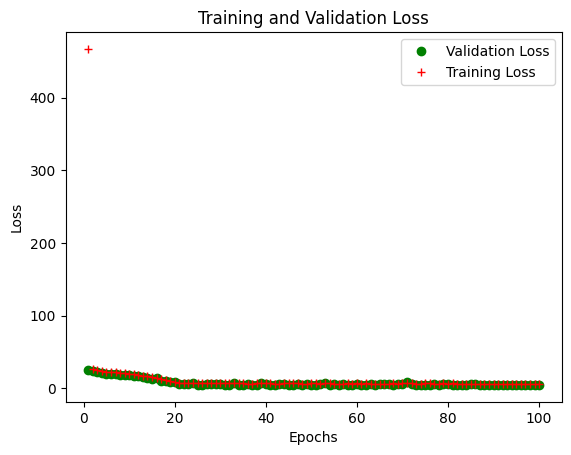

In [27]:
import matplotlib.pyplot as plt

training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, validation_loss, 'go', label='Validation Loss')
plt.plot(epochs, training_loss, 'r+', label='Training Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

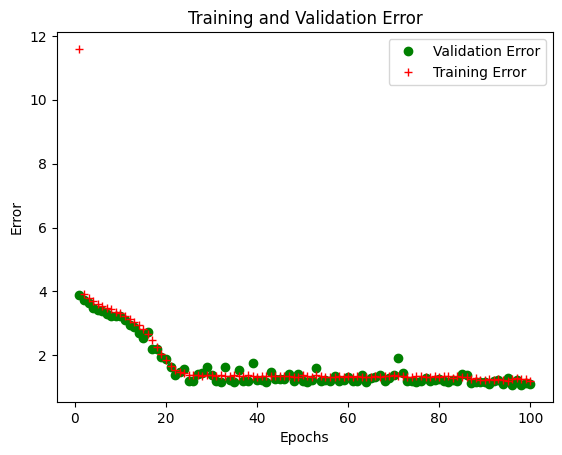

In [28]:
train_error = history.history['mean_absolute_error']
validation_error = history.history['val_mean_absolute_error']
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, validation_error, 'go', label='Validation Error')
plt.plot(epochs, train_error, 'r+', label='Training Error')
plt.title('Training and Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

In [29]:
test_predicted = small_model.predict(x_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [30]:
for index in range(len(test_predicted[:10])):
    print(f'\nReal value: {y_test[index]}')
    print(f'Predicted value: {test_predicted[index]}')
# print(f'Predicted value: {test_predicted[100]}')


Real value: 67
Predicted value: [67.10954]

Real value: 65
Predicted value: [64.89974]

Real value: 64
Predicted value: [64.72554]

Real value: 63
Predicted value: [62.47666]

Real value: 70
Predicted value: [69.47907]

Real value: 66
Predicted value: [66.93816]

Real value: 66
Predicted value: [68.07961]

Real value: 71
Predicted value: [71.78504]

Real value: 65
Predicted value: [63.911884]

Real value: 68
Predicted value: [68.14839]


### Small Model with Regularization and Dropout

In [31]:
from keras import regularizers
from keras.layers import Dense, Dropout, Input

small_model_l2_dropout = models.Sequential()

# The input shape is the number of features because keras needs to know how many dimensions the input has
small_model_l2_dropout.add(Input(shape=(x_train.shape[1],)))
small_model_l2_dropout.add(Dense(32, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
small_model_l2_dropout.add(Dropout(0.5))
small_model_l2_dropout.add(Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
small_model_l2_dropout.add(Dropout(0.5))
small_model_l2_dropout.add(Dense(1, kernel_regularizer=regularizers.l2(0.001), activation='linear'))

In [32]:
from keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

small_model_l2_dropout.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

In [33]:
history_l2_dropout = small_model_l2_dropout.fit(x_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2411.8918 - mean_absolute_error: 41.3777 - val_loss: 233.6731 - val_mean_absolute_error: 14.5391
Epoch 2/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 864.7593 - mean_absolute_error: 24.2788 - val_loss: 155.0803 - val_mean_absolute_error: 11.7817
Epoch 3/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 744.8839 - mean_absolute_error: 22.3965 - val_loss: 112.6355 - val_mean_absolute_error: 9.8871
Epoch 4/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 712.4860 - mean_absolute_error: 21.9656 - val_loss: 140.8115 - val_mean_absolute_error: 11.3293
Epoch 5/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 650.6229 - mean_absolute_error: 20.8850 - val_loss: 120.4904 - val_mean_absolute_error: 10.4091
Epoch 6/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 607.4493 - mean_absolute_error: 20.2116 - val_loss: 98.3873 - val_mean_absolute_error: 9.2940
Epoch 7/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss:

### Small Model with Regularization results

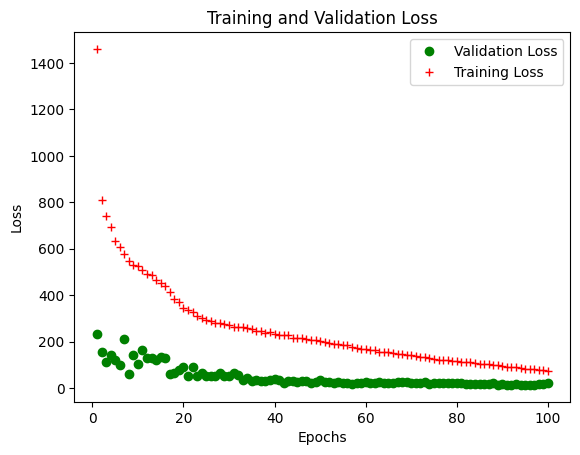

In [34]:
import matplotlib.pyplot as plt

training_loss = history_l2_dropout.history['loss']
validation_loss = history_l2_dropout.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, validation_loss, 'go', label='Validation Loss')
plt.plot(epochs, training_loss, 'r+', label='Training Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

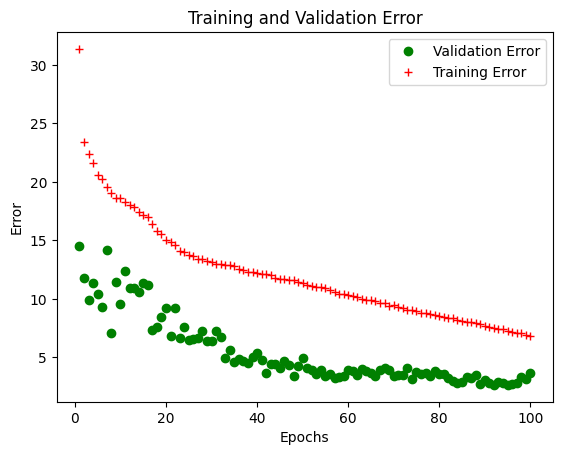

In [35]:
train_error = history_l2_dropout.history['mean_absolute_error']
validation_error = history_l2_dropout.history['val_mean_absolute_error']
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, validation_error, 'go', label='Validation Error')
plt.plot(epochs, train_error, 'r+', label='Training Error')
plt.title('Training and Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

In [36]:
test_predicted_l2_dropout = small_model_l2_dropout.predict(x_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [37]:
for index in range(len(test_predicted_l2_dropout[:10])):
    print(f'\nReal value: {y_test[index]}')
    print(f'Predicted value: {test_predicted_l2_dropout[index]}')


Real value: 67
Predicted value: [63.81134]

Real value: 65
Predicted value: [63.78814]

Real value: 64
Predicted value: [63.4316]

Real value: 63
Predicted value: [63.23208]

Real value: 70
Predicted value: [65.84291]

Real value: 66
Predicted value: [65.255844]

Real value: 66
Predicted value: [64.70181]

Real value: 71
Predicted value: [66.50628]

Real value: 65
Predicted value: [63.17334]

Real value: 68
Predicted value: [65.77508]


### Model with Raw Data

Let's try to fit a model with the raw data, with no data augmentation.

Label enconding to avoid problems during training with keras:

In [38]:
x_categorical = df.select_dtypes(include=['object'])
x_categorical.head()

,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Motivation_Level,Internet_Access,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender
0,Low,High,No,Low,Yes,Low,Medium,Public,Positive,No,High School,Near,Male
1,Low,Medium,No,Low,Yes,Medium,Medium,Public,Negative,No,College,Moderate,Female
2,Medium,Medium,Yes,Medium,Yes,Medium,Medium,Public,Neutral,No,Postgraduate,Near,Male
3,Low,Medium,Yes,Medium,Yes,Medium,Medium,Public,Negative,No,High School,Moderate,Male
4,Medium,Medium,Yes,Medium,Yes,Medium,High,Public,Neutral,No,College,Near,Female


In [39]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

df_encoded = df.copy()

label_encoders = {}

for column in x_categorical.columns:
    lbl_enc = LabelEncoder()
    df_encoded[column] = lbl_enc.fit_transform(df[column])
    label_encoders[column] = lbl_enc

In [40]:
df_encoded.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,1,0,0,7,73,1,1,0,1,2,1,2,3,0,1,2,1,67
1,19,64,1,2,0,8,59,1,1,2,2,2,1,0,4,0,0,1,0,61
2,24,98,2,2,1,7,91,2,1,2,2,2,1,1,4,0,2,2,1,74
3,29,89,1,2,1,8,98,2,1,1,2,2,1,0,4,0,1,1,1,71
4,19,92,2,2,1,6,65,2,1,3,2,0,1,1,4,0,0,2,0,70


In [41]:
print(f"Encoded data shape: {df_encoded.shape}")

Encoded data shape: (6378, 20)


Let's select which features are going to be used to train the model:

In [42]:
from sklearn.feature_selection import SelectKBest, f_classif

# Selección de las mejores características
x = df_encoded.drop('Exam_Score', axis=1)
y = df_encoded['Exam_Score']

selector = SelectKBest(score_func=f_classif, k='all')

fit = selector.fit(x, y)
scores = fit.scores_

print(pd.DataFrame({'Feature': x.columns, 'Score': scores}).sort_values(by='Score', ascending=False))

                       Feature       Score
1                   Attendance  128.968833
0                Hours_Studied   56.678412
6              Previous_Scores    7.459964
9            Tutoring_Sessions    5.892080
15       Learning_Disabilities    3.294999
3          Access_to_Resources    2.715888
13              Peer_Influence    2.626521
17          Distance_from_Home    2.617815
2         Parental_Involvement    2.365768
14           Physical_Activity    1.815777
8              Internet_Access    1.682315
4   Extracurricular_Activities    1.595365
11             Teacher_Quality    1.336516
18                      Gender    1.202499
16    Parental_Education_Level    0.975026
12                 School_Type    0.972795
10               Family_Income    0.969312
5                  Sleep_Hours    0.924798
7             Motivation_Level    0.887107


In [43]:
important_features = [
    'Attendance',
    'Hours_Studied',
    'Previous_Scores',
    'Tutoring_Sessions',
    'Learning_Disabilities',
    'Access_to_Resources',
    'Peer_Influence'
]

x = df_encoded[important_features]
y = df_encoded['Exam_Score']

Of course, the data must be partitioned into train, validation and test data:

In [44]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=999)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=999)

x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [45]:
print(f'Train size: {x_train.shape[0]} samples')
print(f'Validation size: {x_val.shape[0]} samples')
print(f'Test size: {x_test.shape[0]} samples')

print(f'Train labels size: {y_train.shape[0]} samples')
print(f'Validation labels size: {y_val.shape[0]} samples')
print(f'Test labels size: {y_test.shape[0]} samples')

Train size: 5102 samples
Validation size: 638 samples
Test size: 638 samples
Train labels size: 5102 samples
Validation labels size: 638 samples
Test labels size: 638 samples


Now, let's create the keras model:

In [46]:
from keras import regularizers, models
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam

raw_data_model = models.Sequential()

raw_data_model.add(Input(shape=(x_train.shape[1],)))
raw_data_model.add(Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
raw_data_model.add(Dropout(0.18128765768009508))
raw_data_model.add(Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
raw_data_model.add(Dropout(0.18128765768009508))
raw_data_model.add(Dense(1, kernel_regularizer=regularizers.l2(0.001), activation='linear'))


optimizer = Adam(learning_rate=0.04992792927397439)

raw_data_model.compile(optimizer=optimizer,
                       loss='mean_squared_error',
                       metrics=['mean_absolute_error'])

history_raw_data_model = raw_data_model.fit(x_train,
                                            y_train,
                                            epochs=100,
                                            batch_size=32,
                                            validation_data=(x_val, y_val),
                                            verbose=1)

Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 619.7794 - mean_absolute_error: 18.4513 - val_loss: 142.4471 - val_mean_absolute_error: 11.4636
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 235.6135 - mean_absolute_error: 12.2256 - val_loss: 119.9532 - val_mean_absolute_error: 10.5236
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 190.2616 - mean_absolute_error: 10.8175 - val_loss: 100.1836 - val_mean_absolute_error: 9.5605
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 214.5358 - mean_absolute_error: 11.7331 - val_loss: 11.4954 - val_mean_absolute_error: 2.5429
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 160.5240 - mean_absolute_error: 10.1717 - val_loss: 142.8751 - val_mean_absolute_error: 11.7333
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 171.8445 - mean_absolute_error: 10.4396 - val_loss: 39.8323 - val_mean_absolute_error: 5.9274
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11

### Model with Raw Data results

Let's see if the model with the raw data imporved.

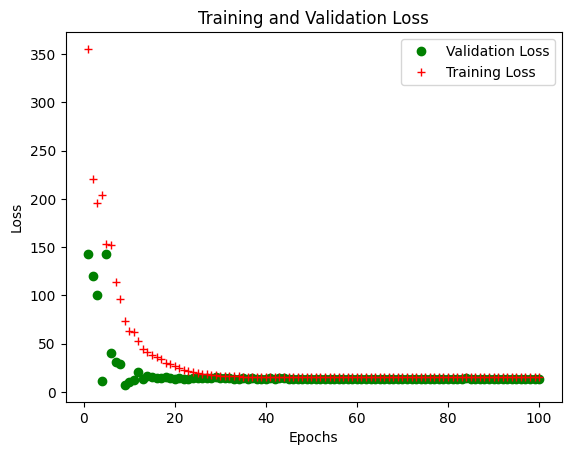

In [47]:
import matplotlib.pyplot as plt

training_loss = history_raw_data_model.history['loss']
validation_loss = history_raw_data_model.history['val_loss']

epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, validation_loss, 'go', label='Validation Loss')
plt.plot(epochs, training_loss, 'r+', label='Training Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

Enlarged chart:

The following chart shows the loss behaviour on validation and train data in the epochs 5-30.

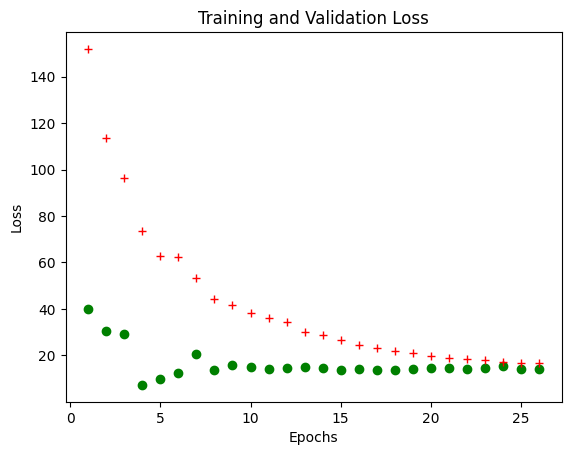

In [48]:
import matplotlib.pyplot as plt

training_loss = history_raw_data_model.history['loss'][5:31]
validation_loss = history_raw_data_model.history['val_loss'][5:31]

# epochs = range(1, len(training_loss) + 1)
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, validation_loss, 'go', label='Validation Loss')
plt.plot(epochs, training_loss, 'r+', label='Training Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

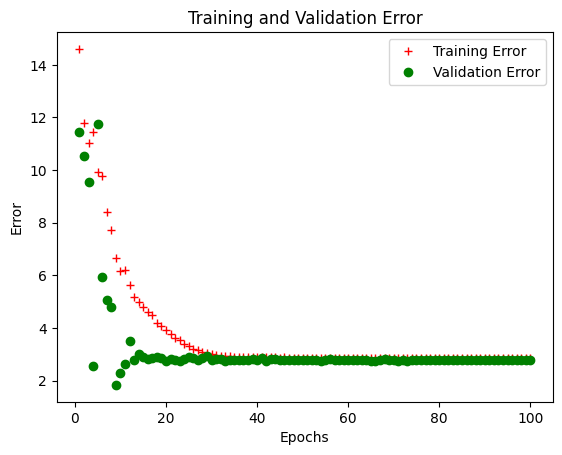

In [50]:
import matplotlib.pyplot as plt

training_error = history_raw_data_model.history['mean_absolute_error']
validation_error = history_raw_data_model.history['val_mean_absolute_error']

epochs = range(1, len(training_error) + 1)

plt.plot(epochs, training_error, 'r+', label='Training Error')
plt.plot(epochs, validation_error, 'go', label='Validation Error')


plt.legend()
plt.title('Training and Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Error')

plt.show()

Let's try to predict some values with this model:

In [51]:
test_predicted_raw = raw_data_model.predict(x_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [52]:
for index in range(len(test_predicted_raw[:20])):
    print(f'\nReal value: {y_test[index]}')
    print(f'Predicted value: {test_predicted_raw[index]}')


Real value: 65
Predicted value: [67.325874]

Real value: 68
Predicted value: [67.325874]

Real value: 73
Predicted value: [67.325874]

Real value: 69
Predicted value: [67.325874]

Real value: 64
Predicted value: [67.325874]

Real value: 69
Predicted value: [67.325874]

Real value: 63
Predicted value: [67.325874]

Real value: 64
Predicted value: [67.325874]

Real value: 70
Predicted value: [67.325874]

Real value: 61
Predicted value: [67.325874]

Real value: 63
Predicted value: [67.325874]

Real value: 66
Predicted value: [67.325874]

Real value: 67
Predicted value: [67.325874]

Real value: 66
Predicted value: [67.325874]

Real value: 64
Predicted value: [67.325874]

Real value: 67
Predicted value: [67.325874]

Real value: 70
Predicted value: [67.325874]

Real value: 64
Predicted value: [67.325874]

Real value: 71
Predicted value: [67.325874]

Real value: 70
Predicted value: [67.325874]


---

## Bayesian Optimization

### Finding Best Hyperparameters

Let's find the better values for the model hyperparameters.

In [54]:
!pip install scikit-optimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam

# search space
param_space = [
    Real(1e-6, 1e-1, name='learning_rate', prior='log-uniform'),
    Real(0.1, 0.9, name='dropout_rate'),
    Integer(10, 100, name='epochs'),
    Integer(16, 64, name='dense_units_1'),
    Integer(16, 64, name='dense_units_2')
]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.7 MB/s eta 0:00:00


This is the objective function. After finding the better hyperparameters values, the `objective()` function will be called to train a model with those values:

In [55]:
@use_named_args(param_space)
def objective(learning_rate, dropout_rate, epochs, dense_units_1, dense_units_2):
    model = Sequential()
    model.add(Input(shape=(x_train.shape[1],)))
    model.add(Dense(dense_units_1, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units_2, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_regularizer=regularizers.l2(0.001), activation='linear'))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    history = model.fit(x_train, y_train, batch_size=32, epochs=epochs, verbose=0, validation_data=(x_val, y_val))

    loss_test, mae_test = model.evaluate(x_test, y_test, verbose=0)

    return loss_test

In [57]:
res = gp_minimize(objective, param_space, n_calls=50, random_state=0)

The best hyperparameters are:

In [58]:
print("Mejores hiperparámetros encontrados:")
print(f"Learning rate: {res.x[0]}")
print(f"Dropout rate: {res.x[1]}")
print(f"epchs: {res.x[2]}")
print(f"Units in Dense Layer 1: {res.x[3]}")
print(f"Units in Dense Layer 2: {res.x[4]}")

Mejores hiperparámetros encontrados:
Learning rate: 0.0223940051875643
Dropout rate: 0.1
epchs: 100
Units in Dense Layer 1: 47
Units in Dense Layer 2: 16


### Optimized Model

Now, let's create a model using the values we've just found as the best ones.

In [59]:
from keras import regularizers
from keras.layers import Dense, Dropout, Input

small_model_optimized = models.Sequential()

# The input shape is the number of features because keras needs to know how many dimensions the input has
small_model_optimized.add(Input(shape=(x_train.shape[1],)))
small_model_optimized.add(Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
small_model_optimized.add(Dropout(0.18128765768009508))
small_model_optimized.add(Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
small_model_optimized.add(Dropout(0.18128765768009508))
small_model_optimized.add(Dense(1, kernel_regularizer=regularizers.l2(0.001), activation='linear'))

from keras.optimizers import Adam

optimizer = Adam(learning_rate=0.04992792927397439)

small_model_optimized.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

history_optimized = small_model_optimized.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 458.6772 - mean_absolute_error: 15.8558 - val_loss: 19.0236 - val_mean_absolute_error: 3.3668
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 251.8792 - mean_absolute_error: 12.6800 - val_loss: 72.1180 - val_mean_absolute_error: 7.8498
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 198.7971 - mean_absolute_error: 11.1977 - val_loss: 285.2984 - val_mean_absolute_error: 16.7264
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 229.4601 - mean_absolute_error: 12.2060 - val_loss: 11.1398 - val_mean_absolute_error: 2.4012
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 160.9502 - mean_absolute_error: 9.9793 - val_loss: 43.4708 - val_mean_absolute_error: 6.1841
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 144.7926 - mean_absolute_error: 9.6010 - val_loss: 60.4095 - val_mean_absolute_error: 7.4666
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 115.4918 - mean_

### Optimized Model results

Let's compare the results of the optimized model.

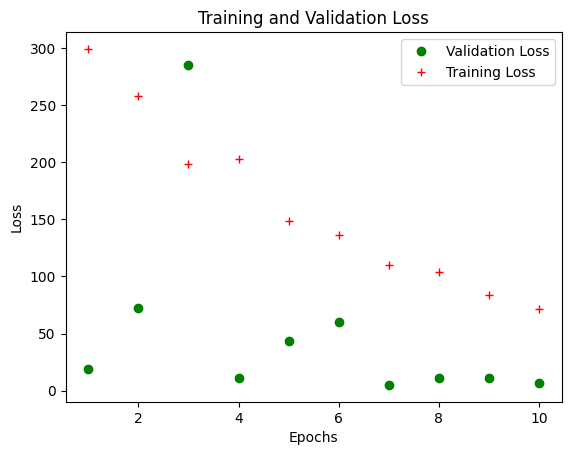

In [60]:
import matplotlib.pyplot as plt

training_loss = history_optimized.history['loss']
validation_loss = history_optimized.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, validation_loss, 'go', label='Validation Loss')
plt.plot(epochs, training_loss, 'r+', label='Training Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

With respect to the results obtained with the other models, we can see that the optimized model has achieved a lower loss at the training time. However the validation loss remains quite similar.

Furthermore, the optimized model seems to have reached a sweet spot between validation loss and training loss, which is a positive sign, as it indicates that the model is not overfitting. This suggests that we can tune it a little further to improve its performance.

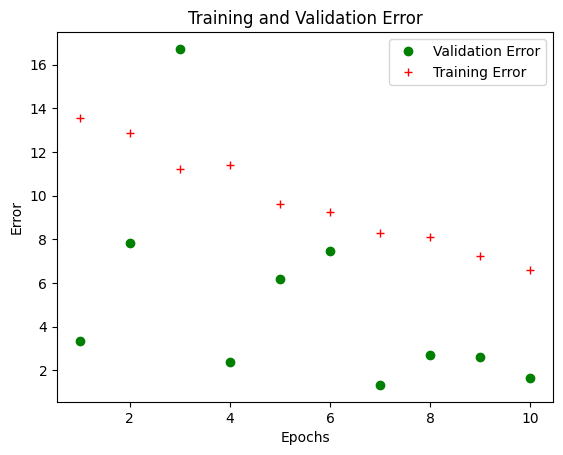

In [61]:
train_error = history_optimized.history['mean_absolute_error']
validation_error = history_optimized.history['val_mean_absolute_error']
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, validation_error, 'go', label='Validation Error')
plt.plot(epochs, train_error, 'r+', label='Training Error')
plt.title('Training and Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

The behavior of the curves indicates that the optimized model is achieving improved accuracy in both the training and validation sets. The fact that the validation MAE does not continue to decrease significantly after the fourth epoch suggests that the model has reached an acceptable performance point and that training for more epochs will probably not improve the results. This is a positive sign that the model is not overfitting, although it would be advisable to make fine adjustments to the hyperparameters to explore possible improvements.

In [62]:
test_predicted_optimized = small_model_optimized.predict(x_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [63]:
for index in range(len(test_predicted_optimized[:10])):
    print(f'\nReal value: {y_test[index]}')
    print(f'Predicted value: {test_predicted_optimized[index]}')


Real value: 65
Predicted value: [66.25662]

Real value: 68
Predicted value: [66.96181]

Real value: 73
Predicted value: [68.2978]

Real value: 69
Predicted value: [67.69879]

Real value: 64
Predicted value: [65.332756]

Real value: 69
Predicted value: [67.97009]

Real value: 63
Predicted value: [62.409927]

Real value: 64
Predicted value: [65.252975]

Real value: 70
Predicted value: [68.81]

Real value: 61
Predicted value: [62.33915]


# CNN Arquitecture

Since the data is tabular and not images, instead of a CNN architecture, it is more common to use a fully connected neural network, also known as MLP (Multilayer Perceptron) or feed-forward network. This architecture is composed of dense layers (fully connected layers) that connect each neuron in a layer with all the neurons in the next one.

Features of an MLP for tabular data
Dense Layers:
Multiple layers with a given number of neurons and activation functions (such as ReLU) are used to learn representations of the data.

Regularization:
It is common to include regularization techniques (such as Dropout or L2) to avoid overfitting, especially when the number of features is high or the data is limited.

Output Layer:
In regression problems (such as predicting the score of an exam), the output layer usually has a single neuron with linear activation to produce a continuous value.

Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1420.2479 - mean_absolute_error: 31.0080 - val_loss: 209.7420 - val_mean_absolute_error: 13.8171
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 595.4774 - mean_absolute_error: 19.7808 - val_loss: 142.0882 - val_mean_absolute_error: 11.2059
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 526.0674 - mean_absolute_error: 18.6988 - val_loss: 66.0981 - val_mean_absolute_error: 7.0209
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 476.7967 - mean_absolute_error: 17.7974 - val_loss: 97.7858 - val_mean_absolute_error: 9.0341
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 426.4894 - mean_absolute_error: 16.7215 - val_loss: 77.6540 - val_mean_absolute_error: 7.8715
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 418.5085 - mean_absolute_error: 16.5592 - val_loss: 55.6531 - val_mean_absolute_error: 6.3742
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 42

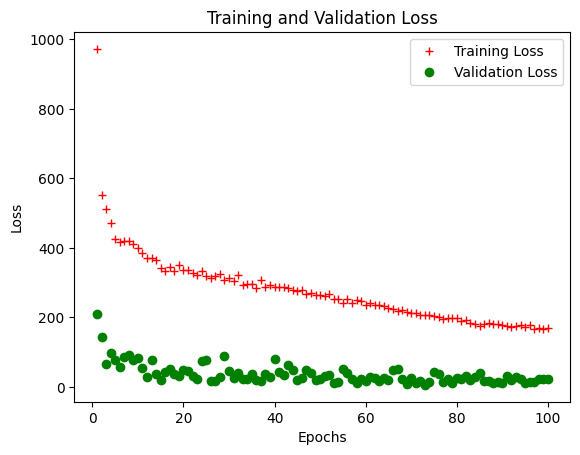

In [66]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras import regularizers
import matplotlib.pyplot as plt

# Definir la arquitectura del modelo
mlpModel = Sequential()
mlpModel.add(Input(shape=(x_train.shape[1],)))
mlpModel.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
mlpModel.add(Dropout(0.5))
mlpModel.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
mlpModel.add(Dropout(0.5))
mlpModel.add(Dense(1, activation='linear'))

# Compilar el modelo
mlpModel.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# Entrenar el modelo usando epochs
history = mlpModel.fit(x_train, y_train,
                    epochs=100,            # Número de épocas
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

# Graficar la evolución de la pérdida (loss) durante el entrenamiento
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs_range = range(1, len(training_loss) + 1)

plt.plot(epochs_range, training_loss, 'r+', label='Training Loss')
plt.plot(epochs_range, validation_loss, 'go', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Possible “sweet spot”

There comes a point where the curves level off: training is close to ~150 and validation is around ~100 (or a close range).
This suggests that the model has found an equilibrium, where learning more does not reduce the validation error much.

In [67]:
# 1. Evaluación en el conjunto de prueba
test_loss, test_mae = mlpModel.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# 2. Generación de predicciones
test_predictions = mlpModel.predict(x_test)

# 3. Comparación de predicciones vs valores reales en las primeras muestras
num_muestras = 5  # Número de ejemplos que quieres imprimir
for i in range(num_muestras):
    print(f"Muestra {i+1}:")
    print(f"  Predicción: {test_predictions[i][0]:.4f}")
    print(f"  Valor real: {y_test[i]}")
    print()


Test Loss: 26.6949
Test MAE: 3.9546
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Muestra 1:
  Predicción: 64.1716
  Valor real: 65

Muestra 2:
  Predicción: 63.0592
  Valor real: 68

Muestra 3:
  Predicción: 63.9229
  Valor real: 73

Muestra 4:
  Predicción: 63.9599
  Valor real: 69

Muestra 5:
  Predicción: 62.1496
  Valor real: 64



#Hiperparameters optimization

Params: lr=0.000921, dropout=0.78, epochs=87, dense1=57, dense2=46 -> val_mae=5.2224
Params: lr=0.000084, dropout=0.34, epochs=15, dense1=29, dense2=39 -> val_mae=7.2936
Params: lr=0.011504, dropout=0.48, epochs=45, dense1=56, dense2=32 -> val_mae=2.9153
Params: lr=0.001741, dropout=0.39, epochs=96, dense1=23, dense2=58 -> val_mae=4.5834
Params: lr=0.000233, dropout=0.74, epochs=57, dense1=49, dense2=51 -> val_mae=19.2199
Params: lr=0.000813, dropout=0.53, epochs=78, dense1=21, dense2=39 -> val_mae=11.5118
Params: lr=0.000009, dropout=0.69, epochs=29, dense1=22, dense2=32 -> val_mae=45.8212
Params: lr=0.000006, dropout=0.28, epochs=45, dense1=59, dense2=38 -> val_mae=7.4610
Params: lr=0.001162, dropout=0.82, epochs=19, dense1=63, dense2=47 -> val_mae=12.6391
Params: lr=0.000007, dropout=0.39, epochs=78, dense1=45, dense2=32 -> val_mae=8.5315
Params: lr=0.002164, dropout=0.79, epochs=100, dense1=63, dense2=44 -> val_mae=4.5258
Params: lr=0.019971, dropout=0.47, epochs=55, dense1=64, den

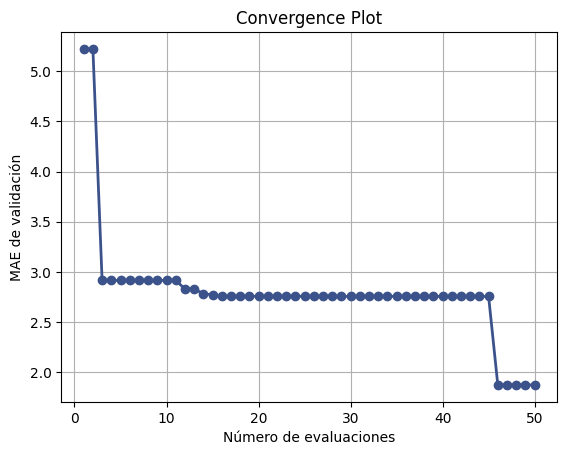

In [68]:
# Importar las librerías necesarias
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras import regularizers
import matplotlib.pyplot as plt

# Definir el espacio de búsqueda de hiperparámetros
param_space = [
    Real(1e-6, 1e-1, name='learning_rate', prior='log-uniform'),
    Real(0.1, 0.9, name='dropout_rate'),
    Integer(10, 100, name='epochs'),
    Integer(16, 64, name='dense_units_1'),
    Integer(16, 64, name='dense_units_2')
]

# Función objetivo para la optimización bayesiana
@use_named_args(param_space)
def objective(learning_rate, dropout_rate, epochs, dense_units_1, dense_units_2):
    # Crear el modelo mlpOptimized
    mlpOptimized = Sequential()
    mlpOptimized.add(Input(shape=(x_train.shape[1],)))
    mlpOptimized.add(Dense(dense_units_1, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    mlpOptimized.add(Dropout(dropout_rate))
    mlpOptimized.add(Dense(dense_units_2, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    mlpOptimized.add(Dropout(dropout_rate))
    mlpOptimized.add(Dense(1, activation='linear'))

    # Compilar el modelo
    mlpOptimized.compile(optimizer=Adam(learning_rate=learning_rate),
                           loss='mean_squared_error',
                           metrics=['mean_absolute_error'])

    # Entrenar el modelo con los datos de entrenamiento y validación
    history = mlpOptimized.fit(x_train, y_train,
                               epochs=epochs,
                               batch_size=32,
                               validation_data=(x_val, y_val),
                               verbose=0)

    # Obtener el MAE de validación de la última época
    val_mae = history.history['val_mean_absolute_error'][-1]
    print(f"Params: lr={learning_rate:.6f}, dropout={dropout_rate:.2f}, epochs={epochs}, dense1={dense_units_1}, dense2={dense_units_2} -> val_mae={val_mae:.4f}")

    return val_mae

# Ejecutar la optimización bayesiana con 50 evaluaciones
res = gp_minimize(objective, param_space, n_calls=50, random_state=0)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(f"Learning rate: {res.x[0]:.6f}")
print(f"Dropout rate: {res.x[1]:.2f}")
print(f"Epochs: {res.x[2]}")
print(f"Dense units in first layer: {res.x[3]}")
print(f"Dense units in second layer: {res.x[4]}")
print(f"MAE de validación: {res.fun:.4f}")

# Graficar la convergencia de la optimización bayesiana
plot_convergence(res)
plt.title("Convergence Plot")
plt.xlabel("Número de evaluaciones")
plt.ylabel("MAE de validación")
plt.show()
